# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно **построить модель для определения стоимости автомобилей**. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [108]:
#conda install -c conda-forge lightgbm

In [1]:
from datetime import date
import datetime as dt
from lightgbm import LGBMRegressor
import pandas as pd
from scipy.stats import mode
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
df = pd.read_csv('/datasets/autos.csv')
print(df.head())
df.info()


           DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf     150000                  0    petrol  volkswagen         NaN   
1    NaN     125000                  5  gasoline        audi         yes   
2  grand     125000                  8  gasoline        jeep         NaN   
3   golf     150000                  6    petrol  volkswagen          no   
4  fabia      90000                  7  gasoline       skoda          no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen 

Так-так-так, датасет не то чтобы совсем плохой, но и шибко хорошим тоже его назвать язык не поворачивается.

Попробуем сделать предобработку с престрастием и просто тупо удалить все наны и посмотрим качество на обоих наборах.

Поехали!


In [2]:
#Посмотрим распределение данных в столбце RegistrationYear
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [3]:
df['DateCrawled'].unique()

array(['2016-03-24 11:52:17', '2016-03-24 10:58:45',
       '2016-03-14 12:52:21', ..., '2016-03-21 09:50:58',
       '2016-03-14 17:48:27', '2016-03-19 18:57:12'], dtype=object)

In [4]:
#почистим от выбросов столбец
df = df.loc[(df.RegistrationYear <=2020) & (df.RegistrationYear >=1900)]
df.shape[0]

354198

In [5]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1960, 1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956,
       1941, 1962, 1929, 1957, 1940, 1949, 2019, 1937, 1951, 1953, 1933,
       1950, 1948, 1952, 1932, 1942, 1935, 1936, 1923, 1930, 1944, 1943,
       1934, 1938, 1928, 1919, 1931, 1915, 1920, 1947, 1927, 1946])

Сама по себе дата создания объявления ни о чем нам не говорит, преобразуем её 
в продолжительность продажи с даты публикации по нынешний день

In [6]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['DateCreated'] = pd.Series(map(lambda x: date.today() - x.date(), list(df['DateCreated'])))
df['How_long_selling'] = df['DateCreated'].astype('timedelta64[D]')
display(df['How_long_selling'].isna().sum())


171

Отлично, теперь заполним пропуски модой

In [7]:
df['How_long_selling'] = df['How_long_selling'].fillna(df['How_long_selling'].mode()[0])
display(df['How_long_selling'].isna().sum())
display(df['How_long_selling'].value_counts())

0

2290.0    13877
2289.0    13308
2304.0    12905
2312.0    12832
2303.0    12684
          ...  
2378.0        1
2437.0        1
2368.0        1
2443.0        1
2388.0        1
Name: How_long_selling, Length: 109, dtype: int64

Вроде неплохо получилось, теперь удалим ненужные для прогноза столбцы.

In [8]:
df.drop(['DateCrawled', 'LastSeen', 'NumberOfPictures', 'DateCreated'], axis=1, inplace=True)
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'PostalCode', 'How_long_selling'],
      dtype='object')

Посмотрим пропуски во всем датасете

In [9]:
df.isna().sum()

Price                    0
VehicleType          37319
RegistrationYear         0
Gearbox              19695
Power                    0
Model                19630
Kilometer                0
RegistrationMonth        0
FuelType             32767
Brand                    0
NotRepaired          71007
PostalCode               0
How_long_selling         0
dtype: int64

Караул, будем заполнять!


In [10]:
#Создадим список изменяемых столбцов
columns_to_replace_list = ['NotRepaired', 'FuelType', 'Gearbox', 'VehicleType']

#Создадим отдельный датасет копированием исходного
df_after_replace = df.copy()

#Сгруппируем ноовый датасет по бренду-модели-году_регистрации
#в качестве агрегирующей функции возьмем моду, методамами transform/fillna заменимнаш одноименные значения в нашем датасете на 
#агрегированные значения из нашей группировоной таблицы
df_after_replace[columns_to_replace_list] = df.groupby(
    ['Brand', 'Model','RegistrationYear'],
    dropna=False
)[columns_to_replace_list].transform(
    lambda x: x.fillna(x.mode()[0]) if len(x.mode()) == 1 else x)
#проверим результат
display(df_after_replace.shape[0])
df_after_replace.isna().sum()

354198

Price                    0
VehicleType          18525
RegistrationYear         0
Gearbox                553
Power                    0
Model                19630
Kilometer                0
RegistrationMonth        0
FuelType               869
Brand                    0
NotRepaired           1475
PostalCode               0
How_long_selling         0
dtype: int64

NotRepaired неплохо так получился, теперь посмотрим что там с FuelType

In [11]:
#выведем распределение значений в столбце FuelType
display(df_after_replace['FuelType'].value_counts())
#заменим значение gasoline на petrol так как и то ти то означает бензин
df_after_replace['FuelType'] = df_after_replace['FuelType'].replace('gasoline','petrol')

petrol      243484
gasoline    103396
lpg           5342
cng            565
hybrid         236
other          216
electric        90
Name: FuelType, dtype: int64

In [12]:
display(df_after_replace['FuelType'].value_counts())

petrol      346880
lpg           5342
cng            565
hybrid         236
other          216
electric        90
Name: FuelType, dtype: int64

Теперь то же самое для столбца **Model**

In [13]:
df_after_replace['Model'] = df_after_replace.groupby(
    ['Brand','VehicleType','Gearbox', 'FuelType', 'RegistrationYear', 'RegistrationMonth'],
    dropna=False
)['Model'].transform(
    lambda x: x.fillna(x.mode()[0]) if len(x.mode()) == 1 else x)

In [14]:
display(df_after_replace['Model'].isna().sum().sum())

6184

C 19630 пропусков на 6184 - результат вполне неплохой, дальше то же самое для столбца Power

In [15]:
#выведем распределение 
display(df_after_replace['Power'].value_counts())
#посмотрим выбросы 
(df_after_replace['Power'] >700).value_counts()


0       40098
75      24020
60      15897
150     14590
101     13298
        ...  
9013        1
4400        1
1689        1
1433        1
6006        1
Name: Power, Length: 711, dtype: int64

False    353855
True        343
Name: Power, dtype: int64

Теперь можно заполнить нулевые значения по моде агрегированных данных столбцов **'Brand', 'Model', 'VehicleType', 'Gearbox'**

In [16]:
df_after_replace['Power'] = df_after_replace.query(
    'Power != 0').groupby(
    ['Brand', 'Model', 'VehicleType', 'Gearbox'],
    dropna=False)['Power'].transform(
    lambda x: x.replace(0, x.mode()[0]) if len(x.mode()) == 1 else x)

display(df_after_replace['Power'].value_counts())
display(df_after_replace['Power'].shape[0])

75.0      24020
60.0      15897
150.0     14590
101.0     13298
140.0     12852
          ...  
8500.0        1
574.0         1
1054.0        1
1988.0        1
9010.0        1
Name: Power, Length: 710, dtype: int64

354198

Отлично, теперь фильтром уберем **совсем уж супер спорткары**

In [17]:
(df_after_replace['Power'] >700).value_counts()

False    353855
True        343
Name: Power, dtype: int64

343 "спорткара" вроде совсем неплохо, посмотрим не изменилось ли чего с пропусками?

In [18]:
df_after_replace['Power'].isna().sum().sum()

40098

Мрак, по всей видимости все нули стали пропусками... ну, что тут поделаешь, будем лечить!

In [19]:
df_after_replace['Power'] = df_after_replace.query(
    'Power != 0').groupby(
    ['Brand', 'Model', 'VehicleType', 'Gearbox'],
    dropna=False)['Power'].transform(
    lambda x: x.fillna(x.mode()[0]) if len(x.mode()) == 1 else x)

display(df_after_replace['Power'].value_counts())
display(df_after_replace['Power'].shape[0])
print(f'Nan - {df_after_replace["Power"].isna().sum().sum()}')

75.0      30006
60.0      22792
150.0     17078
101.0     15954
140.0     14567
          ...  
8500.0        1
2389.0        1
574.0         1
1054.0        1
9010.0        1
Name: Power, Length: 710, dtype: int64

354198

Nan - 2292


Существенно лучше, теперь можно и фильтровать.

In [20]:
df_after_replace = df_after_replace[(df_after_replace['Power'] <=700) & (df_after_replace['Power'] >=50)]
df_after_replace['Power'].describe()

count    345078.000000
mean        119.678232
std          53.079681
min          50.000000
25%          75.000000
50%         110.000000
75%         147.000000
max         700.000000
Name: Power, dtype: float64

<AxesSubplot:ylabel='Frequency'>

75.0     30006
60.0     22792
150.0    17078
101.0    15954
140.0    14567
         ...  
678.0        1
541.0        1
337.0        1
607.0        1
508.0        1
Name: Power, Length: 410, dtype: int64

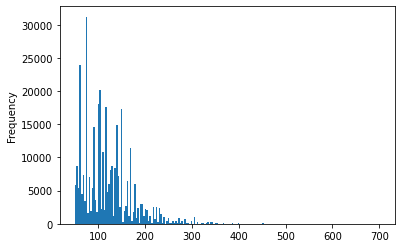

In [21]:
display(df_after_replace['Power'].plot(kind='hist', bins=200))
display(df_after_replace['Power'].value_counts())

Значений улетело немало, но в целом датасет пока критично не потерял. Теперь за RegistrationMonth!

In [22]:
display(df_after_replace['RegistrationMonth'].value_counts())

0     34978
3     33693
6     30802
4     28614
5     28508
7     26577
10    25573
12    23767
11    23735
9     23333
1     22562
8     22152
2     20784
Name: RegistrationMonth, dtype: int64

Уберем нулевой месяц.

In [23]:
df_after_replace['RegistrationMonth'] = df_after_replace.query(
    'RegistrationMonth != 0').groupby(
    ['Kilometer','Price'],
    dropna=False)['RegistrationMonth'].transform(
    lambda x: x.replace(0, x.mode()[0]) if len(x.mode()) == 1 else x)

display(df_after_replace['RegistrationMonth'].value_counts())
display(df_after_replace['RegistrationMonth'].shape[0])

3.0     33693
6.0     30802
4.0     28614
5.0     28508
7.0     26577
10.0    25573
12.0    23767
11.0    23735
9.0     23333
1.0     22562
8.0     22152
2.0     20784
Name: RegistrationMonth, dtype: int64

345078

In [24]:
display(df_after_replace['RegistrationMonth'].isna().sum())

34978

Опять та же история, теперь заполнять модой.

In [25]:
df_after_replace['RegistrationMonth'] = df_after_replace.query(
    'RegistrationMonth != 0').groupby(
    ['Kilometer','Price'],
    dropna=False
)['RegistrationMonth'].transform(
    lambda x: x.fillna(x.mode()[0]) if len(x.mode()) == 1 else x)

In [26]:
display(df_after_replace['RegistrationMonth'].value_counts())
display(df_after_replace['RegistrationMonth'].isna().sum())

3.0     49818
6.0     36659
4.0     31391
5.0     30340
7.0     27346
10.0    26309
11.0    24338
12.0    24316
1.0     23902
9.0     23670
8.0     22557
2.0     20998
Name: RegistrationMonth, dtype: int64

3434

Другое дело! А остатки можно и отбросить фильтром.

In [27]:
df_after_replace = df_after_replace[df_after_replace['RegistrationMonth'].notna()]
display(df_after_replace['RegistrationMonth'].value_counts())
display(df_after_replace['RegistrationMonth'].isna().sum())
df_after_replace.shape[0]

3.0     49818
6.0     36659
4.0     31391
5.0     30340
7.0     27346
10.0    26309
11.0    24338
12.0    24316
1.0     23902
9.0     23670
8.0     22557
2.0     20998
Name: RegistrationMonth, dtype: int64

0

341644

In [28]:
display(df_after_replace.shape[0])
df_after_replace.isna().sum()


341644

Price                    0
VehicleType          16931
RegistrationYear         0
Gearbox                 81
Power                    0
Model                 4668
Kilometer                0
RegistrationMonth        0
FuelType               485
Brand                    0
NotRepaired            933
PostalCode               0
How_long_selling         0
dtype: int64

Беремся за последний злой столбец VehicleType, а после можно и отбросить оставшиеся пропуски

In [29]:
df_after_replace['VehicleType'] = df_after_replace.groupby(
    ['Brand','Model','NotRepaired'],
    dropna=False
)['VehicleType'].transform(
    lambda x: x.fillna(x.mode()[0]) if len(x.mode()) == 1 else x)

In [30]:
df_after_replace.isna().sum().sum()

6417

Посмотрим ещё раз на данные

In [31]:
display(df_after_replace.shape[0])
df_after_replace.isna().sum()

341644

Price                   0
VehicleType           250
RegistrationYear        0
Gearbox                81
Power                   0
Model                4668
Kilometer               0
RegistrationMonth       0
FuelType              485
Brand                   0
NotRepaired           933
PostalCode              0
How_long_selling        0
dtype: int64

В целом нормально, можно остатки выбросить.

In [32]:
df_after_replace.dropna(inplace=True)
display(df_after_replace.isna().sum().sum())
df_after_replace.shape[0]

0

335886

In [33]:
print(f'В целом неплохо вышло, предобработанный сет вышел меньше исходного всего на -  {(1-335886/354369):.2%}')

В целом неплохо вышло, предобработанный сет вышел меньше исходного всего на -  5.22%


Теперь как писалось выше создадим датасет с ленивой предобработкой - тупо удалим все пропуски и потеряем треть данных

In [34]:
df_after_dropna = df.copy().dropna()
display(df_after_dropna.info())
display(df_after_dropna.shape)
display(df_after_replace.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              245814 non-null  int64  
 1   VehicleType        245814 non-null  object 
 2   RegistrationYear   245814 non-null  int64  
 3   Gearbox            245814 non-null  object 
 4   Power              245814 non-null  int64  
 5   Model              245814 non-null  object 
 6   Kilometer          245814 non-null  int64  
 7   RegistrationMonth  245814 non-null  int64  
 8   FuelType           245814 non-null  object 
 9   Brand              245814 non-null  object 
 10  NotRepaired        245814 non-null  object 
 11  PostalCode         245814 non-null  int64  
 12  How_long_selling   245814 non-null  float64
dtypes: float64(1), int64(6), object(6)
memory usage: 26.3+ MB


None

(245814, 13)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,How_long_selling
0,480,sedan,1993,manual,75.0,golf,150000,9.0,petrol,volkswagen,no,70435,2300.0
2,9800,suv,2004,auto,163.0,grand,125000,8.0,petrol,jeep,no,90480,2310.0
3,1500,small,2001,manual,75.0,golf,150000,6.0,petrol,volkswagen,no,91074,2307.0
4,3600,small,2008,manual,69.0,fabia,90000,7.0,petrol,skoda,no,60437,2293.0
5,650,sedan,1995,manual,102.0,3er,150000,10.0,petrol,bmw,yes,33775,2289.0


In [35]:
print(f'Лениво предобработанный сет вышел меньше исходного всего на -  {(1-245814/354369):.2%}')


Лениво предобработанный сет вышел меньше исходного всего на -  30.63%


In [36]:
#Контрольная проверка
display(df_after_replace.isna().sum().sum())
display(df_after_dropna.isna().sum().sum())
display(df_after_replace.shape)
display(df_after_dropna.shape)

0

0

(335886, 13)

(245814, 13)

С кодированием у меня какие-то проблемы были и я решил, то, что могу кодировать руками без особых усилий, закодирую руками. Собственно, вот.


In [37]:
df_after_replace = df_after_replace.replace({'NotRepaired':{'no': 0,'yes': 1}})
df_after_dropna = df_after_dropna.replace({'NotRepaired':{'no': 0,'yes': 1}})

df_after_replace = df_after_replace.replace({'Gearbox':{'manual': 0,'auto': 1}})
df_after_dropna = df_after_dropna.replace({'Gearbox':{'manual': 0,'auto': 1}})

In [38]:
#Проверимся
df_after_replace.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,How_long_selling
0,480,sedan,1993,0,75.0,golf,150000,9.0,petrol,volkswagen,0,70435,2300.0
2,9800,suv,2004,1,163.0,grand,125000,8.0,petrol,jeep,0,90480,2310.0
3,1500,small,2001,0,75.0,golf,150000,6.0,petrol,volkswagen,0,91074,2307.0
4,3600,small,2008,0,69.0,fabia,90000,7.0,petrol,skoda,0,60437,2293.0
5,650,sedan,1995,0,102.0,3er,150000,10.0,petrol,bmw,1,33775,2289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,0,125.0,zafira,150000,3.0,petrol,opel,0,26624,2290.0
354364,0,small,2005,0,75.0,colt,150000,7.0,petrol,mitsubishi,1,2694,2290.0
354366,1199,convertible,2000,1,101.0,fortwo,125000,3.0,petrol,smart,0,26135,2290.0
354367,9200,bus,1996,0,102.0,transporter,150000,3.0,petrol,volkswagen,0,87439,2290.0


In [40]:
#посмотрим пропуски
df_after_replace.isna().sum()


Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
PostalCode           0
How_long_selling     0
dtype: int64

Отлично, можно кодировать.

In [40]:
#При кодировке всех кодируемых фич сразу появляется большое количество пропусков, потому кодировал парами.
#OHE энкодер было бы лучше применить, но классов в каждой фиче слишком много, датасет разрастается слишком сильно.
encoder_after_replace = OrdinalEncoder()
encoder_after_drop = OrdinalEncoder()

encoder_after_replace.fit(df_after_replace[['VehicleType', 'FuelType']])
df_after_replace[['VehicleType', 'FuelType']] = encoder_after_replace.transform(df_after_replace[['VehicleType', 'FuelType']])

encoder_after_drop.fit(df_after_dropna[['VehicleType', 'FuelType']])
df_after_dropna[['VehicleType', 'FuelType']] = encoder_after_drop.transform(df_after_dropna[['VehicleType', 'FuelType']])



In [41]:
encoder_after_replace.fit(df_after_replace[['Gearbox', 'Model']])
df_after_replace[['Gearbox', 'Model']] = encoder_after_replace.transform(df_after_replace[['Gearbox', 'Model']])

encoder_after_drop.fit(df_after_dropna[['Gearbox', 'Model']])
df_after_dropna[['Gearbox', 'Model']] = encoder_after_drop.transform(df_after_dropna[['Gearbox', 'Model']])


In [42]:
encoder_after_replace.fit(df_after_replace['Brand'])
df_after_replace['Brand'] = encoder_after_replace.transform(df_after_replace['Brand'])

encoder_after_drop.fit(df_after_dropna['Brand'])
df_after_dropna['Brand'] = encoder_after_drop.transform(df_after_dropna['Brand', 'PostalCode'])


In [43]:
#Посмотрим пропуски 
display(df_after_replace.isna().sum().sum())

0

In [44]:
# изменим тип данных на целочисленный 
df_after_replace = df_after_replace.astype('int')
df_after_dropna = df_after_dropna.astype('int')
df_after_replace.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,How_long_selling
0,480,4,1993,0,75,116,150000,9,5,37,0,4892,2299
2,9800,6,2004,1,163,117,125000,8,5,14,0,6985,2309
3,1500,5,2001,0,75,116,150000,6,5,37,0,7025,2306
4,3600,5,2008,0,69,101,90000,7,5,31,0,4206,2292
5,650,4,1995,0,102,11,150000,10,5,2,1,2373,2288


In [42]:
df_after_dropna.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,How_long_selling
3,1500,5.0,65.0,0.0,75,116.0,150000,6.0,6.0,37.0,0.0,6974.0,2307.0
4,3600,5.0,72.0,0.0,69,101.0,90000,7.0,2.0,31.0,0.0,4170.0,2293.0
5,650,4.0,59.0,0.0,102,11.0,150000,10.0,6.0,2.0,1.0,2341.0,2289.0
6,2200,1.0,68.0,0.0,109,8.0,150000,8.0,6.0,25.0,0.0,4593.0,2292.0
7,0,4.0,44.0,0.0,50,166.0,40000,7.0,6.0,37.0,0.0,1143.0,2303.0


In [41]:
categorical_features = ['VehicleType',
                        'RegistrationYear',
                       'Gearbox',
                       'Model',
                       'RegistrationMonth',
                       'FuelType',
                       'Brand',
                        'NotRepaired',
                        'PostalCode']

Вроде всё хорошо, можно приступать к созданию моделей.

## Обучение моделей

#### Для начала выделим фичи и таргет, а после поделим датасет на тестовую и обучающую выборки. Датасет с предобработкой.

In [44]:
features_after_replace = df_after_replace.drop('Price', axis=1)
target_after_replace = df_after_replace['Price']
features_train_replace, features_test_replace, target_train_replace, target_test_replace = train_test_split(features_after_replace, target_after_replace, test_size = .25, random_state = 12)

print(target_after_replace.shape)
print(features_after_replace.info())
print(features_after_replace.head())

(335886,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 335886 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        335886 non-null  float64
 1   RegistrationYear   335886 non-null  float64
 2   Gearbox            335886 non-null  float64
 3   Power              335886 non-null  float64
 4   Model              335886 non-null  float64
 5   Kilometer          335886 non-null  int64  
 6   RegistrationMonth  335886 non-null  float64
 7   FuelType           335886 non-null  float64
 8   Brand              335886 non-null  float64
 9   NotRepaired        335886 non-null  float64
 10  PostalCode         335886 non-null  float64
 11  How_long_selling   335886 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 33.3 MB
None
   VehicleType  RegistrationYear  Gearbox  Power  Model  Kilometer  \
0          4.0              52.0      0.0   75.0  116.0     150000

#### То же самое для датасета с удаленными данными.

In [45]:
features_after_drop = df_after_dropna.drop('Price', axis=1)
target_after_drop = df_after_dropna['Price']
features_train_drop, features_test_drop, target_train_drop, target_test_drop = train_test_split(features_after_drop, target_after_drop, test_size = .25, random_state = 12)

print(target_after_drop.shape)
print(features_after_drop.shape)
print(features_after_drop.columns)

(245814,)
(245814, 12)
Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'PostalCode', 'How_long_selling'],
      dtype='object')


#### Теперь масштабируем оба сета данных.

In [46]:
features_after_replace.columns
numeric_features = ['Kilometer', 'How_long_selling']
scaler_replace = StandardScaler()
features_after_replace[numeric_features] = pd.DataFrame(scaler_replace.fit_transform(features_after_replace[numeric_features]), columns=numeric_features)

scaler_drop = StandardScaler()
features_after_drop[numeric_features] = pd.DataFrame(scaler_drop.fit_transform(features_after_drop[numeric_features]), columns=numeric_features)

In [50]:
features_after_replace.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,How_long_selling
0,4,1993,0,75,116,0.565795,9,5,37,0,4892,-0.340291
2,6,2004,1,163,117,0.565795,8,5,14,0,6985,0.404593
3,5,2001,0,75,116,-1.076649,6,5,37,0,7025,-1.085174
4,5,2008,0,69,101,0.565795,7,5,31,0,4206,-1.510822
5,4,1995,0,102,11,0.565795,10,5,2,1,2373,-1.191586


## Певым алгоритмом попробуем RandomForest с подбором гиперпараметров рандомайздсёчем

In [47]:
features_train_replace.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'PostalCode', 'How_long_selling'],
      dtype='object')

In [48]:

categorical_features = ['VehicleType',
                        'RegistrationYear',
                        'Gearbox',
                        'Model',
                        'RegistrationMonth',
                        'FuelType',
                        'Brand',
                        'NotRepaired', 'PostalCode']

#### Датасет здорового человека

In [ ]:
%%time

params = {'random_state':[12],
         'n_estimators':range(30,65,5),
         'max_depth':range(20,40,2),
          'n_jobs':[-1]
         }
model_rf_replace = RandomForestRegressor()
random_search_rf = RandomizedSearchCV(estimator=model_rf_replace, param_distributions=params, scoring='neg_root_mean_squared_error')
random_search_rf.fit(features_train_replace, target_train_replace)
print(f'Лучшие параметры для случайного леса: {random_search_rf.best_params_}')
print(f'Лучшая метрика: {random_search_rf.best_score_}')

#### Обучим лес с подобранными выше гиперпараметрами на тренировочной выборке датасета здорового человека

In [50]:
%%time 

model_rf = RandomForestRegressor(max_depth=28, n_estimators=60,random_state=12)
model_rf.fit(features_train_replace, target_train_replace)

CPU times: user 1min 8s, sys: 1.09 s, total: 1min 10s
Wall time: 1min 10s


RandomForestRegressor(max_depth=28, n_estimators=60, random_state=12)

In [63]:
%%time 
predictions_rf = model_rf.predict(features_train_replace)
print(f'RMSE for random forest - {mean_squared_error(target_train_replace, predictions_rf)**0.5}')

RMSE for random forest - 665.0743593433567
CPU times: user 4.02 s, sys: 187 ms, total: 4.2 s
Wall time: 4.27 s


#### Сразу же проверим на тестовой 

In [64]:
%%time 

model_rf = RandomForestRegressor(max_depth=28, n_estimators=60,random_state=12)
model_rf.fit(features_train_replace, target_train_replace)

CPU times: user 50.2 s, sys: 463 ms, total: 50.7 s
Wall time: 50.7 s


RandomForestRegressor(max_depth=28, n_estimators=60, random_state=12)

In [65]:
%time


predictions_rf = model_rf.predict(features_test_replace)
print(f'RMSE for random forest - {mean_squared_error(target_test_replace, predictions_rf)**0.5}')

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
RMSE for random forest - 1735.1763814150258


Вроде ничего метрика вышла, а ведь это с рандомайзд сёчем, значит не переобученная...

#### Датасет без предобработки

In [57]:
%%time

params = {'random_state':[12],
         'n_estimators':range(1,100,10),
         'max_depth':range(1,40,5),
         'n_jobs':[-1]
         }

model_rf_drop = RandomForestRegressor()
random_search_drop = RandomizedSearchCV(estimator=model_rf_drop, param_distributions=params, scoring='neg_root_mean_squared_error')
random_search_drop.fit(features_train_drop, target_train_drop)
print(f'Лучшие параметры для случайного леса: {random_search_drop.best_params_}')

Лучшие параметры для случайного леса: {'random_state': 12, 'n_jobs': -1, 'n_estimators': 61, 'max_depth': 31}
CPU times: user 1min 39s, sys: 24.3 s, total: 2min 3s
Wall time: 3min 11s


In [66]:
random_search_drop.best_score_

-1674.7790222777135

#### Обучим модель на тренировочной выборке и снимем метрику

In [59]:
%%time 
model_rf_drop = RandomForestRegressor(max_depth=31, n_estimators=61,random_state=12)
model_rf_drop.fit(features_train_drop, target_train_drop)


CPU times: user 38.1 s, sys: 362 ms, total: 38.5 s
Wall time: 38.5 s


RandomForestRegressor(max_depth=31, n_estimators=61, random_state=12)

In [60]:
%%time
predictions_rf_drop = model_rf_drop.predict(features_train_drop)
print(f'RMSE for random forest - {mean_squared_error(target_train_drop, predictions_rf_drop)**0.5}')

RMSE for random forest - 627.7272486412388
CPU times: user 2.89 s, sys: 170 ms, total: 3.06 s
Wall time: 3.11 s


Сильно, теперь проверимся на **тесте**

In [61]:
%%time 
model_rf_drop = RandomForestRegressor(max_depth=31, n_estimators=61,random_state=12)
model_rf_drop.fit(features_train_drop, target_train_drop)

CPU times: user 38 s, sys: 344 ms, total: 38.3 s
Wall time: 38.4 s


RandomForestRegressor(max_depth=31, n_estimators=61, random_state=12)

In [67]:
%%time
predictions_rf_drop = model_rf_drop.predict(features_test_drop)
print(f'RMSE for random forest - {mean_squared_error(target_test_drop, predictions_rf_drop)**0.5}')

RMSE for random forest - 1655.1998551961183
CPU times: user 1.2 s, sys: 255 ms, total: 1.45 s
Wall time: 1.57 s


In [69]:
RandomForest = ["665.0743593433567", "50.4 s", "4,27 s",
                "1735.1763814150258", "50.7 s", "3.1 µs",
                "627.7272486412388", "38.5 s", "3.1 s",
                "1655.1998551961183", "38.4 s", "1.57 s"]
Scores = pd.DataFrame(RandomForest, index = ['RMSE on train data',
                                 'Education wall time:',
                                 'Prediction wall time:',                                             
                                 'RMSE on test data',
                                 'Education wall time:',
                                 'Prediction wall time:',
                                 'RMSE on train smokers data',
                                 'Education wall time:',
                                 'Prediction wall time:',
                                 'RMSE on test smokers data',
                                 'Education wall time:',
                                 'Prediction wall time:'],
                      columns = ['RandomForest'])
Scores

,RandomForest
RMSE on train data,665.0743593433567
Education wall time:,50.4 s
Prediction wall time:,"4,27 s"
RMSE on test data,1735.1763814150258
Education wall time:,50.7 s
Prediction wall time:,3.1 µs
RMSE on train smokers data,627.7272486412388
Education wall time:,38.5 s
Prediction wall time:,3.1 s
RMSE on test smokers data,1655.1998551961183


## Теперь попробуем подобрать гиперпараметры к CatBoostRegressor тем же RandomizedSearche'ем и обучить модели с полученными гиперпараметрами

#### Датасет здорового человека

In [70]:
%%time

params_cat = {'cat_features':[categorical_features],
              'iterations':range(1,1000,10),
              'depth':range(1,16,1)
         }
model_cat_replace = CatBoostRegressor(cat_features =categorical_features)
random_search_cat = RandomizedSearchCV(estimator=model_cat_replace, param_distributions=params_cat, scoring='neg_root_mean_squared_error')
random_search_cat.fit(features_train_replace, target_train_replace)
print(f'Лучшие параметры для случайного леса: {random_search_cat.best_params_}')
print(f'Лучшая метрика: {random_search_cat.best_score_}')

Learning rate set to 0.103056
0:	learn: 4187.6898919	total: 150ms	remaining: 2m 15s
1:	learn: 3899.9915954	total: 217ms	remaining: 1m 37s
2:	learn: 3647.8328301	total: 294ms	remaining: 1m 28s
3:	learn: 3423.9060704	total: 373ms	remaining: 1m 23s
4:	learn: 3229.6009068	total: 431ms	remaining: 1m 17s
5:	learn: 3061.7306016	total: 501ms	remaining: 1m 14s
6:	learn: 2912.8901953	total: 576ms	remaining: 1m 13s
7:	learn: 2785.3708426	total: 627ms	remaining: 1m 9s
8:	learn: 2675.4567381	total: 704ms	remaining: 1m 9s
9:	learn: 2578.6304762	total: 769ms	remaining: 1m 8s
10:	learn: 2497.0349293	total: 830ms	remaining: 1m 7s
11:	learn: 2425.7504641	total: 904ms	remaining: 1m 7s
12:	learn: 2364.0879585	total: 968ms	remaining: 1m 6s
13:	learn: 2310.1930982	total: 1.03s	remaining: 1m 5s
14:	learn: 2263.0596389	total: 1.08s	remaining: 1m 3s
15:	learn: 2223.6631234	total: 1.14s	remaining: 1m 3s
16:	learn: 2189.5359637	total: 1.2s	remaining: 1m 2s
17:	learn: 2156.8123451	total: 1.28s	remaining: 1m 2s
18

### Параметры подобраны, теперь обучим и снимем метрику на обучающей выборке

In [71]:
%%time
cat_replace = CatBoostRegressor(iterations=661, depth=11, loss_function='RMSE', cat_features = categorical_features)
cat_replace.fit(features_train_replace, target_train_replace)

Learning rate set to 0.137326
0:	learn: 4072.9363131	total: 153ms	remaining: 1m 41s
1:	learn: 3694.3068422	total: 304ms	remaining: 1m 40s
2:	learn: 3372.1144333	total: 432ms	remaining: 1m 34s
3:	learn: 3099.3413644	total: 605ms	remaining: 1m 39s
4:	learn: 2879.1190430	total: 758ms	remaining: 1m 39s
5:	learn: 2693.6670421	total: 917ms	remaining: 1m 40s
6:	learn: 2541.0647281	total: 1.06s	remaining: 1m 39s
7:	learn: 2419.2400882	total: 1.23s	remaining: 1m 40s
8:	learn: 2318.0119625	total: 1.36s	remaining: 1m 38s
9:	learn: 2234.7495459	total: 1.48s	remaining: 1m 36s
10:	learn: 2167.4753480	total: 1.62s	remaining: 1m 35s
11:	learn: 2111.1064727	total: 1.79s	remaining: 1m 37s
12:	learn: 2066.1844126	total: 1.94s	remaining: 1m 36s
13:	learn: 2026.8119225	total: 2.08s	remaining: 1m 36s
14:	learn: 1995.6113315	total: 2.22s	remaining: 1m 35s
15:	learn: 1967.9950071	total: 2.35s	remaining: 1m 34s
16:	learn: 1944.2243492	total: 2.48s	remaining: 1m 34s
17:	learn: 1925.7837223	total: 2.64s	remainin

In [120]:
%%time

predictions_rf_replace_train = cat_replace.predict(features_train_replace)
print(f'RMSE for CatBoostRegressor on train data - {mean_squared_error(target_train_replace, predictions_rf_replace_train)**0.5}')

RMSE for CatBoostRegressor on train data - 1345.3211476495583
CPU times: user 7.5 s, sys: 394 ms, total: 7.9 s
Wall time: 1.52 s


### Проверимся на тестовой

In [122]:
Scores['CatBoost'] = ['1345.3211476495583','1min 54s','1.52 s',
                      '1692.652673433219', '1min 55s','437 ms',
                     '0', '0 s','0 s',
                      '0', '0 s', '0 s']
Scores

,RandomForest,CatBoost,LGBM
RMSE on train data,665.0743593433567,1345.3211476495583,1372.5904094886632
Education wall time:,50.4 s,1min 54s,6.77 s
Prediction wall time:,"4,27 s",1.52 s,1.53 s
RMSE on test data,1735.1763814150258,1692.652673433219,1741.6487017046472
Education wall time:,50.7 s,1min 55s,6.7 s
Prediction wall time:,3.1 µs,437 ms,535 ms
RMSE on train smokers data,627.7272486412388,0,0
Education wall time:,38.5 s,0 s,0
Prediction wall time:,3.1 s,0 s,0
RMSE on test smokers data,1655.1998551961183,0,0


In [73]:
%%time
cat_replace = CatBoostRegressor(iterations=661, depth=11, loss_function='RMSE', cat_features =categorical_features)
cat_replace.fit(features_train_replace, target_train_replace)


Learning rate set to 0.137326
0:	learn: 4072.9363131	total: 240ms	remaining: 2m 38s
1:	learn: 3694.3068422	total: 411ms	remaining: 2m 15s
2:	learn: 3372.1144333	total: 551ms	remaining: 2m
3:	learn: 3099.3413644	total: 750ms	remaining: 2m 3s
4:	learn: 2879.1190430	total: 925ms	remaining: 2m 1s
5:	learn: 2693.6670421	total: 1.12s	remaining: 2m 1s
6:	learn: 2541.0647281	total: 1.3s	remaining: 2m 1s
7:	learn: 2419.2400882	total: 1.48s	remaining: 2m 1s
8:	learn: 2318.0119625	total: 1.65s	remaining: 1m 59s
9:	learn: 2234.7495459	total: 1.76s	remaining: 1m 54s
10:	learn: 2167.4753480	total: 1.92s	remaining: 1m 53s
11:	learn: 2111.1064727	total: 2.09s	remaining: 1m 52s
12:	learn: 2066.1844126	total: 2.24s	remaining: 1m 51s
13:	learn: 2026.8119225	total: 2.39s	remaining: 1m 50s
14:	learn: 1995.6113315	total: 2.54s	remaining: 1m 49s
15:	learn: 1967.9950071	total: 2.68s	remaining: 1m 47s
16:	learn: 1944.2243492	total: 2.82s	remaining: 1m 47s
17:	learn: 1925.7837223	total: 2.97s	remaining: 1m 46s


In [121]:
%%time
predictions_rf_replace_test = cat_replace.predict(features_test_replace)
print(f'RMSE for CatBoostRegressor on test data - {mean_squared_error(target_test_replace, predictions_rf_replace_test)**0.5}')


RMSE for CatBoostRegressor on test data - 1692.652673433219
CPU times: user 2.43 s, sys: 30.3 ms, total: 2.46 s
Wall time: 437 ms


### Теперь всё то же самое, только на сете курильщика

In [ ]:
%%time

params_cat_drop = {'cat_features':[categorical_features],
                   'iterations':range(1,1000,10),
                   'depth':range(1,40,5)
         }
model_cat_drop = CatBoostRegressor(cat_features =categorical_features)
random_search_cat_drop = RandomizedSearchCV(estimator=model_cat_drop, param_distributions=params_cat_drop, scoring='neg_root_mean_squared_error')
random_search_cat_drop.fit(features_train_replace, target_train_replace)
print(f'Лучшие параметры для случайного леса: {random_search_cat_drop.best_params_}')
print(f'Лучшая метрика: {random_search_cat_drop.best_score_}')

### Параметры подобраны, теперь обучим и снимем метрику на обучающей выборке

In [ ]:
%%time
cat_drop = CatBoostRegressor(iterations=531, depth=11, loss_function='RMSE', cat_features =categorical_features)
cat_drop.fit(features_train_drop, target_train_drop)
predictions_rf_drop = model_rf.predict(features_train_drop)
print(f'RMSE for CatBoostRegressor on train data- {mean_squared_error(target_train_drop, predictions_rf_drop)**0.5}')


### То же самое на тесте

In [ ]:
%%time
cat_drop = CatBoostRegressor(iterations=531, depth=11, loss_function='RMSE')
cat_drop.fit(features_train_drop, target_train_drop)
predictions_rf_drop = model_rf.predict(features_test_drop)
print(f'RMSE for CatBoostRegressor on test data- {mean_squared_error(target_test_drop, predictions_rf_drop)**0.5}')



### Теперь попробуем подобрать гиперпараметры к LGBMRegressor тем же RandomizedSearche'ем и обучить модельки

In [96]:
features_train_for_LGBM_replace = features_train_replace.copy()
features_test_for_LGBM_replace = features_test_replace.copy()

features_train_for_LGBM_replace[categorical_features] = features_train_for_LGBM_replace[
    categorical_features].astype('category')
features_test_for_LGBM_replace[categorical_features] = features_test_for_LGBM_replace[
    categorical_features].astype('category')


features_train_for_LGBM_drop = features_train_drop.copy()
features_test_for_LGBM_drop = features_test_drop.copy()

features_train_for_LGBM_drop[categorical_features] = features_train_for_LGBM_drop[
    categorical_features].astype('category')
features_test_for_LGBM_drop[categorical_features] = features_test_for_LGBM_drop[
    categorical_features].astype('category')

In [97]:
features_train_for_LGBM_replace.dtypes

VehicleType          category
RegistrationYear     category
Gearbox              category
Power                   int64
Model                category
Kilometer               int64
RegistrationMonth    category
FuelType             category
Brand                category
NotRepaired          category
PostalCode           category
How_long_selling        int64
dtype: object

In [98]:
features_train_for_LGBM_drop.dtypes

VehicleType          category
RegistrationYear     category
Gearbox              category
Power                   int64
Model                category
Kilometer               int64
RegistrationMonth    category
FuelType             category
Brand                category
NotRepaired          category
PostalCode           category
How_long_selling        int64
dtype: object

In [112]:
%%time

params_LGBM = {'random_state':[12],
         'n_estimators':range(1,1000,10),
         'max_depth':range(1,40,5),
          'n_jobs':[-1]
         }
model_LGBM_replace = LGBMRegressor()
random_search_LGBM = RandomizedSearchCV(estimator=model_LGBM_replace, param_distributions=params_LGBM, scoring='neg_root_mean_squared_error')
random_search_LGBM.fit(features_train_for_LGBM_replace, target_train_replace)
print(f'Лучшие параметры для случайного леса: {random_search_LGBM.best_params_}')
print(f'Лучшая метрика: {random_search_LGBM.best_score_}')

Лучшие параметры для случайного леса: {'random_state': 12, 'n_jobs': -1, 'n_estimators': 541, 'max_depth': 36}
Лучшая метрика: -1739.5841140716554
CPU times: user 20min 48s, sys: 3min 13s, total: 24min 1s
Wall time: 3min 12s


### Параметры подобраны, теперь обучим и снимем метрику на обучающей выборке

In [113]:
%%time

LGBM_replace = LGBMRegressor(n_estimators=541, max_depth=36,verbose=10, metric='rmse')
LGBM_replace.fit(features_train_for_LGBM_replace, target_train_replace)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895592
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.238119
[LightGBM] [Debug] init for col-wise cost 0.003673 seconds, init for row-wise cost 0.003979 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 7744
[LightGBM] [Info] Number of data points in the train set: 251914, number of used features: 12
[LightGBM] [Info] Start training from score 4496.625896
[LightGBM] [Debug] Traine

LGBMRegressor(max_depth=36, metric='rmse', n_estimators=541, verbose=10)

In [114]:
%%time
predictions_LGBM_replace = LGBM_replace.predict(features_train_for_LGBM_replace)
print(f'RMSE for LGBMRegressor on train data- {mean_squared_error(target_train_replace, predictions_LGBM_replace)**0.5}')

RMSE for LGBMRegressor on train data- 1372.5904094886632
CPU times: user 11 s, sys: 124 ms, total: 11.1 s
Wall time: 1.53 s


### То же самое на тесте

In [115]:
%%time

LGBM_replace = LGBMRegressor(n_estimators=541, max_depth=36, verbose=10, metric='rmse')
LGBM_replace.fit(features_train_for_LGBM_replace, target_train_replace)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895592
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.238119
[LightGBM] [Debug] init for col-wise cost 0.003847 seconds, init for row-wise cost 0.005688 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 7744
[LightGBM] [Info] Number of data points in the train set: 251914, number of used features: 12
[LightGBM] [Info] Start training from score 4496.625896
[LightGBM] [Debug] Traine

LGBMRegressor(max_depth=36, metric='rmse', n_estimators=541, verbose=10)

In [116]:
%%time

predictions_LGBM_replace_test = LGBM_replace.predict(features_test_for_LGBM_replace)
print(f'RMSE for LGBMRegressor on test data- {mean_squared_error(target_test_replace, predictions_LGBM_replace_test)**0.5}')

RMSE for LGBMRegressor on test data- 1741.6487017046472
CPU times: user 3.83 s, sys: 33.3 ms, total: 3.86 s
Wall time: 535 ms


### Датасет без предобработки

In [117]:
Scores['LGBM'] = ['1372.5904094886632','6.77 s', '1.53 s',
                  '1741.6487017046472', '6.7 s', '535 ms',
                  '0', '0', '0',
                  '0', '0', '0',]
Scores

,RandomForest,CatBoost,LGBM
RMSE on train data,665.0743593433567,665.0743593433567,1372.5904094886632
Education wall time:,50.4 s,1min 54s,6.77 s
Prediction wall time:,"4,27 s",5.5 s,1.53 s
RMSE on test data,1735.1763814150258,1735.1763814150258,1741.6487017046472
Education wall time:,50.7 s,1min 55s,6.7 s
Prediction wall time:,3.1 µs,2.5 s,535 ms
RMSE on train smokers data,627.7272486412388,0,0
Education wall time:,38.5 s,0 s,0
Prediction wall time:,3.1 s,0 s,0
RMSE on test smokers data,1655.1998551961183,0,0


In [105]:
%%time

params_LGBM_drop = {'random_state':[12],
         'n_estimators':range(1,1000,10),
         'max_depth':range(1,40,5),
          'n_jobs':[-1]
         }
model_LGBM_drop = LGBMRegressor()
random_search_LGBM_drop = RandomizedSearchCV(estimator=model_LGBM_drop, param_distributions=params_LGBM_drop, scoring='neg_root_mean_squared_error')
random_search_LGBM_drop.fit(features_train_drop, target_train_drop)
print(f'Лучшие параметры для случайного леса: {random_search_LGBM_drop.best_params_}')
print(f'Лучшая метрика: {random_search_LGBM_drop.best_score_}')

Лучшие параметры для случайного леса: {'random_state': 12, 'n_jobs': -1, 'n_estimators': 901, 'max_depth': 11}
Лучшая метрика: -1622.0830221176134
CPU times: user 6min 39s, sys: 39.4 s, total: 7min 19s
Wall time: 1min 1s


### Параметры подобраны, теперь обучим и снимем метрику на обучающей выборке

In [106]:
%%time

LGBM_drop = LGBMRegressor(n_estimators=951, max_depth=11, metric='rmse')
LGBM_drop.fit(features_train_drop, target_train_drop)
predictions_LGBM_drop_train = LGBM_drop.predict(features_train_drop)
print(f'RMSE for LGBMRegressor on test data- {mean_squared_error(target_train_drop, predictions_LGBM_drop_train)**0.5}')

RMSE for LGBMRegressor on test data- 1384.163813278764
CPU times: user 28.4 s, sys: 1.82 s, total: 30.2 s
Wall time: 4.13 s


### То же самое на тесте

In [107]:
%%time

LGBM_drop = LGBMRegressor(n_estimators=951, max_depth=11, verbose=10, metric='rmse')
LGBM_drop.fit(features_train_drop, target_train_drop)
predictions_LGBM_drop_test = LGBM_drop.predict(features_test_drop)
print(f'RMSE for LGBMRegressor on test data- {mean_squared_error(target_test_drop, predictions_LGBM_drop_test)**0.5}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.839450
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.154595
[LightGBM] [Debug] init for col-wise cost 0.002941 seconds, init for row-wise cost 0.005091 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 184360, number of used features: 12
[LightGBM] [Info] Start training from score 5120.536423
[LightGBM] [Debug] Trained

## Анализ моделей

In [123]:
Scores

,RandomForest,CatBoost,LGBM
RMSE on train data,665.0743593433567,1345.3211476495583,1372.5904094886632
Education wall time:,50.4 s,1min 54s,6.77 s
Prediction wall time:,"4,27 s",1.52 s,1.53 s
RMSE on test data,1735.1763814150258,1692.652673433219,1741.6487017046472
Education wall time:,50.7 s,1min 55s,6.7 s
Prediction wall time:,3.1 µs,437 ms,535 ms
RMSE on train smokers data,627.7272486412388,0,0
Education wall time:,38.5 s,0 s,0
Prediction wall time:,3.1 s,0 s,0
RMSE on test smokers data,1655.1998551961183,0,0


## Общий вывод:
На тестовой выборке лучше всех себя показал(разумеется) правильный алгоритм от Яндекса:)), Победитель в категория метрика - его величество CatBooost, только учился долговато. А вот лучшую скорость обучения показал LGBM. Предсказания RandomForest.